# Notebook for Borg et al. (2024), Submitted to ICSME
This is the Jupyter Notebook accompanying the paper "PAPER TITLE" by Markus Borg, Marwa Ezzouhri, and Adam Tornhill.

## General preparations
Import libraries and read the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

*maintainability_data.csv* contains code ground truth labels for 304 files from Schnappinger et al. (2020) and many metrics from static code analysis tools. More specifically:
- Majority voting labels by human experts: Readability, Understandability, Complexity (inverted), Modularization (inverted), and **Overall** (just in this study).
- **Code_Health**: Code Health extracted using CodeScene Community Edition 6.4.13.
- **TD_Ratio** and **TD_Time**: Extracted using SonarQube Community Edition Version 10.0 (build 68432).
- **MI**: Microsoft Maintainability Index obtained from MetricsTree.
- Many code metrics from Bertrand et al. (2023) extracted using Javanalyzer. We use a subset of the metrics to train **SotA ML** and **nos** (number of statements) for the naïve **LoC baseline** classifier.

In [2]:
df = pd.read_csv('maintainability_data.csv', sep=';')

We continue by adding a column with ground truth labels for the binary prediction problem. We follow the same procedure as in previous work by Schnappinger et al. (2021) and Bertrand et al. (2023).
- **Overall** <= 1. Maintainable, i.e., a file that is easy to maintain.
- **Overall** >= 2. Non-maintainable, i.e., a file that is a problem to maintain.

Our primary use case is to *identify files that are problematic to maintain*. Thus, we add a ground truth column that matches this, i.e.,
- True = A file that is truly difficult to maintain.
- False = A file that is maintainable.

This enables a more relevant discussion of true/false positives/negatives as follows:
- True Positive (TP): A file that is correctly predicted as non-maintainable. This is helpful tool output.
- False Positive (FP): A file that is incorrectly highlighted as non-maintainable. This is annoying.
- True Negatives (TN): A file that is correctly predicted as maintainable. This brings limited value.
- False Negatives (FN): A file that is incorrectly highlighted as maintainable. This gives a false sense of security.

For our intended use case of maintainability prediction, false positives are a bigger problem than false negatives. In the Maintainability Dataset, the set of maintainable files is the majority class.

Note that the ground truth in Bertrand et al. (2023) is the inverse, and we adjust for this accordingly in the reproduction of their results. After successfully reproducing the results, we train SotA ML using our preferred ground. We notice that the SotA ML results drop as the majority class (maintainable files) becomes the minority class and vice versa.

In [3]:
df['ground_truth'] = df['Overall'].apply(lambda x: True if x >= 2 else False)

In [4]:
df

,projectname,packageandclass,path,Readability,Understandability,Complexity_inv,Modularization_inv,Overall,Code_Health,TD_Time,...,non_m,nop,nos,nos_am,nos_deeper_4,nos_lm,nos_m,rfc,rfc_ic,ground_truth
0,aoi,artofillusion.animation.ActorEditorWindow,aoi\sourcefiles\ArtOfIllusion\src\artofillusio...,1,2,2,1,2,8.99,242,...,691,1,451,28.30769,3,145,322,61,72,True
1,aoi,artofillusion.animation.AnimationPreviewer,aoi\sourcefiles\ArtOfIllusion\src\artofillusio...,2,2,1,1,3,8.73,354,...,555,1,289,48.50000,3,141,281,37,37,True
2,aoi,artofillusion.animation.distortion.CustomDisto...,aoi\sourcefiles\ArtOfIllusion\src\artofillusio...,1,3,1,1,2,8.96,25,...,270,1,110,32.00000,0,51,109,16,16,True
3,aoi,artofillusion.animation.FilterParameterTrack,aoi\sourcefiles\ArtOfIllusion\src\artofillusio...,1,2,1,0,2,9.24,144,...,730,1,393,16.65385,0,109,392,77,77,True
4,aoi,artofillusion.animation.IKTrack,aoi\sourcefiles\ArtOfIllusion\src\artofillusio...,1,2,1,0,2,9.84,264,...,414,1,464,13.55000,0,50,241,49,68,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,junit4,org.junit.runners.parameterized.BlockJUnit4Cla...,junit4\sourcefiles\src\main\java\org\junit\run...,1,1,2,2,1,9.87,105,...,232,1,141,11.92000,3,37,140,28,28,False
300,junit4,org.junit.runners.parameterized.BlockJUnit4Cla...,junit4\sourcefiles\src\main\java\org\junit\run...,0,0,3,3,0,10.00,0,...,6,1,5,2.00000,0,3,4,2,2,False
301,junit4,org.junit.runners.parameterized.TestWithParame...,junit4\sourcefiles\src\main\java\org\junit\run...,0,0,3,3,0,10.00,0,...,103,0,62,9.13000,0,22,61,11,11,False
302,junit4,org.junit.validator.AnnotationsValidator,junit4\sourcefiles\src\main\java\org\junit\val...,1,1,2,2,1,10.00,7,...,15,1,85,5.50000,0,10,11,2,8,False


## Reproducing the results for SotA ML

First, we reproduce the results from Bertrand et al. (2023) corresponding to the best ensemble classifier. The code in this section is copyrighted by onepoint and contributors and can be found on GitLab: https://gitlab.com/onepoint/research/maintainability-dataset-analysis

We have only extracted the code for this project.

MIT License

Copyright (c) 2022 onepoint and contributors

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Preparations

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [10]:
METRIC_COLUMNS = ["nos", "non", "non_m", "nos_m",
                  "non_am", "nos_am", "non_lm", "nos_lm",
                  "mll", "nos_deeper_4",
                  "cbo", "cbod", "cboi", "cgc", "cyc", "dac", "dit", "lcom4", "lpc",
                  "mnd", "mpc", "nlam", "nle", "noa", "noc", "nod", "noi", "noi_ic",
                  "nolm", "nom", "nop", "rfc", "rfc_ic", ]

X = df[METRIC_COLUMNS]
y = ~df['ground_truth'] # inverted ground truth as explained above

X = X.values

In [11]:
#The best model from Bertrand et al. (2023)
BinaryClassifier = AdaBoostClassifier(n_estimators=150, learning_rate=0.5)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=33)

In [12]:
# List to store the predicted probabilities for each fold
probabilities_list = []

# List to store various prediction metrics for each fold
fprs = []
tprs = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
f05_scores = []
f2_scores = []
auc_scores = []

### For each fold, train the best ensemble classifier and record the results

In [13]:
# Training the Model
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split the data into training and test sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model on the training set
    BinaryClassifier.fit(X_train, y_train)
    
    # Performance metric values
    y_pred = BinaryClassifier.predict(X_test)

    # Record the scores in the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    f05_scores.append(fbeta_score(y_test, y_pred, beta=0.5))
    f2_scores.append(fbeta_score(y_test, y_pred, beta=2))

    # Obtain the predicted probabilities for the positive class
    y_proba = BinaryClassifier.predict_proba(X_test)[:, 1]
  
    # Store the predicted probabilities in a list with a unique variable name
    variable_name = f'v{i+1}'
    exec(f"{variable_name} = y_proba")
    
    # Add the predicted probabilities to the list
    probabilities_list.append(y_proba)

    # Calculate the AUC-ROC score for this fold
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    fprs.append(fpr)
    tprs.append(tpr)
    auc_scores.append(auc(fpr, tpr))

### Calculate the mean results

In [14]:
# Initialize a list to store all FPR points
all_fpr = []

# Add all FPR points to the list
for fpr in fprs:
    all_fpr.append(fpr)

# Sort the FPR points
sota_ml_fpr_sorted = np.sort(np.unique(np.concatenate(all_fpr)))

# Compute the mean TPR for each FPR
sota_ml_tpr = np.zeros_like(sota_ml_fpr_sorted, dtype=float)
for fpr, tpr in zip(fprs, tprs):
    sota_ml_tpr += np.interp(sota_ml_fpr_sorted, fpr, tpr)

sota_ml_tpr /= len(fprs)

# Compute the mean of accuracy, precision, and recall
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)

# Calculate the AUC of the mean ROC curve
mean_auc = auc(sota_ml_fpr_sorted, sota_ml_tpr)

# Print the mean scores
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f}")
print(f"Mean F0.5: {np.mean(f05_scores):.4f}")
print(f"Mean F2: {np.mean(f2_scores):.4f}")

Mean Accuracy: 0.9210
Mean Precision: 0.9495
Mean Recall: 0.9491
Mean F1: 0.9491
Mean F0.5: 0.9493
Mean F2: 0.9491


### Draw the ROC curve for the mean results and print the corresponding AUC

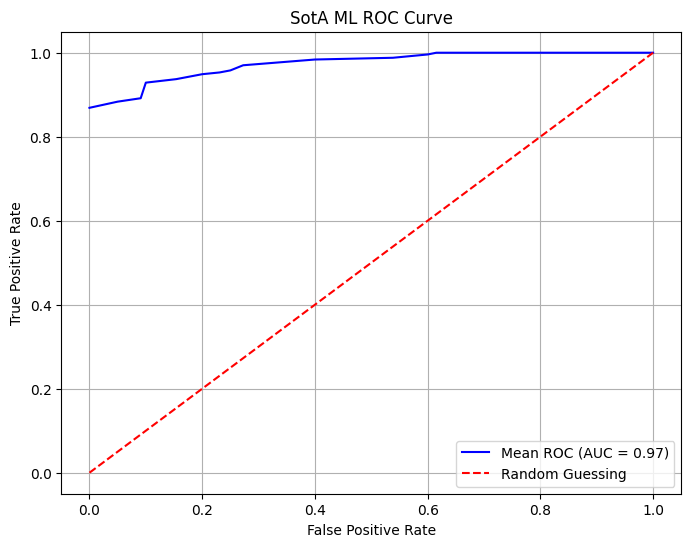

SotA ML AUC: 0.9736


In [15]:
# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.plot(sota_ml_fpr_sorted, sota_ml_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})')

# Plot the dashed line representing the random guessing diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

# Add labels and a legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SotA ML ROC Curve')
plt.legend()
plt.grid(True)

# Display the mean ROC curve
plt.show()

print(f"SotA ML AUC: {mean_auc:.4f}")

We have now successfully reproduced the best results from Bertrand et al. (2023). **SotA ML** has an AUC of 0.97 and F1-score of 0.95.

## Adapting SotaML for our use case.

As previously described, we are interested in identifying problematic files. We know retrain SotA ML with the ground truth we prefer, i.e., the non-maintainable files have the True label.

In [16]:
X_ml = df[METRIC_COLUMNS]
y_ml = df['ground_truth'] # inverted ground truth as explained above

X_ml = X_ml.values

In [17]:
probabilities_list_ml = []

# List to store various prediction metrics for each fold
fprs_ml = []
tprs_ml = []
accuracy_scores_ml = []
precision_scores_ml = []
recall_scores_ml = []
f1_scores_ml = []
f05_scores_ml = []
f2_scores_ml = []
auc_scores_ml = []

In [20]:
# Training the model for our use case
for i, (train_index_ml, test_index_ml) in enumerate(kf.split(X)):
    # Split the data into training and test sets for this fold
    X_train_ml, X_test_ml = X_ml[train_index_ml], X_ml[test_index_ml]
    y_train_ml, y_test_ml = y_ml[train_index_ml], y_ml[test_index_ml]
    
    # Train the model on the training set
    BinaryClassifier.fit(X_train_ml, y_train_ml)
    
    # Performance metric values
    y_pred_ml = BinaryClassifier.predict(X_test_ml)

    # Record the scores in the lists
    accuracy_scores_ml.append(accuracy_score(y_test_ml, y_pred_ml))
    precision_scores_ml.append(precision_score(y_test_ml, y_pred_ml))
    recall_scores_ml.append(recall_score(y_test_ml, y_pred_ml))
    f1_scores_ml.append(f1_score(y_test_ml, y_pred_ml))
    f05_scores_ml.append(fbeta_score(y_test_ml, y_pred_ml, beta=0.5))
    f2_scores_ml.append(fbeta_score(y_test_ml, y_pred_ml, beta=2))

    # Obtain the predicted probabilities for the positive class
    y_proba_ml = BinaryClassifier.predict_proba(X_test_ml)[:, 1]
  
    # Store the predicted probabilities in a list with a unique variable name
    variable_name_ml = f'v{i+1}'
    exec(f"{variable_name_ml} = y_proba")
    
    # Add the predicted probabilities to the list
    probabilities_list.append(y_proba_ml)

    # Calculate the AUC-ROC score for this fold
    fpr_ml, tpr_ml, _ = roc_curve(y_test_ml, y_proba_ml)
    
    fprs_ml.append(fpr_ml)
    tprs_ml.append(tpr_ml)
    auc_scores.append(auc(fpr_ml, tpr_ml))

In [21]:
# Initialize a list to store all FPR points
all_fpr_ml = []

# Add all FPR points to the list
for fpr_ml in fprs_ml:
    all_fpr_ml.append(fpr_ml)

# Sort the FPR points
sota_ml_fpr_sorted_ml = np.sort(np.unique(np.concatenate(all_fpr_ml)))

# Compute the mean TPR for each FPR
sota_ml_tpr_ml = np.zeros_like(sota_ml_fpr_sorted_ml, dtype=float)
for fpr_ml, tpr_ml in zip(fprs_ml, tprs_ml):
    sota_ml_tpr_ml += np.interp(sota_ml_fpr_sorted_ml, fpr_ml, tpr_ml)

sota_ml_tpr_ml /= len(fprs_ml)

# Compute the mean of accuracy, precision, and recall
mean_accuracy_ml = np.mean(accuracy_scores_ml)
mean_precision_ml = np.mean(precision_scores_ml)
mean_recall_ml = np.mean(recall_scores_ml)

# Calculate the AUC of the mean ROC curve
mean_auc_ml = auc(sota_ml_fpr_sorted_ml, sota_ml_tpr_ml)

# Print the mean scores
print(f"Mean Accuracy: {mean_accuracy_ml:.4f}")
print(f"Mean Precision: {mean_precision_ml:.4f}")
print(f"Mean Recall: {mean_recall_ml:.4f}")
print(f"Mean F1: {np.mean(f1_scores_ml):.4f}")
print(f"Mean F0.5: {np.mean(f05_scores_ml):.4f}")
print(f"Mean F2: {np.mean(f2_scores_ml):.4f}")

Mean Accuracy: 0.9205
Mean Precision: 0.8196
Mean Recall: 0.7998
Mean F1: 0.8083
Mean F0.5: 0.8127
Mean F2: 0.8062


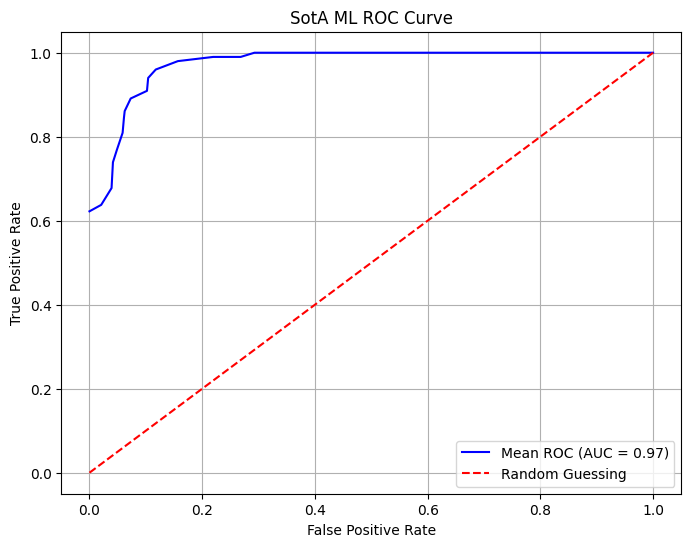

SotA ML AUC: 0.9731


In [22]:
# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.plot(sota_ml_fpr_sorted_ml, sota_ml_tpr_ml, color='b', label=f'Mean ROC (AUC = {mean_auc_ml:.2f})')

# Plot the dashed line representing the random guessing diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

# Add labels and a legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SotA ML ROC Curve')
plt.legend()
plt.grid(True)

# Display the mean ROC curve
plt.show()

print(f"SotA ML AUC: {mean_auc_ml:.4f}")

## Data analysis for the research questions

We continue by presenting the data analysis for the two research questions:

- RQ1: How do contemporary industrial tools’ maintainability assessments compare to SotA ML in matching human experts’ judgments?
- RQ2: What is the comparative predictive power of the tools’ underlying maintainability metrics relative to SotA ML?

### RQ1: Industrial Tools, SotA ML, and Human Experts

RQ1 deals with investigating how well different industrial maintainability prediction approaches perform at binary classification. We study different thresholds.

CodeScene, SonarQube, and Microsoft provide fixed thresholds as follows:
- CodeScene Code Health < 9.0 => non-maintainable file
- SonarQube TD Ratio > 0.05 => non-maintainable file
- Microsoft Maintainability Index < 20 => non-maintainable file

Bertrand et al. (2023) used the following rule for simple LoC-based prediction:
- LoC > 275 => non-maintainable file

We found that SonarQube TD Time is better than the tool's primary maintainability metric (TD Ratio). We identify the best possible threshold value and report it in the paper. Note that only SonarQube gets this special positive treatment.
- SonarQube TD Time > OPTIMAL_VALUE => non-maintainable file

Finally, we explore what the optimal value would be for all the metrics. We don't report this in the paper, but it's interesting to investigate.

### Preparations

We start by defining a function to calculate the metrics we consider in the study.

In [ ]:
def calculate_metrics(df, pred_column):
    """
    Calculate statistics for a given prediction column and return them.

    Parameters:
    - df: DataFrame with your data
    - pred_column: Column name for the prediction results

    Returns:
    - A dictionary with all calculated metrics.
    """
    TP = ((df[pred_column] == True) & (df['Overall'] >= 2)).sum()
    FP = ((df[pred_column] == True) & (df['Overall'] <= 1)).sum()
    TN = ((df[pred_column] == False) & (df['Overall'] <= 1)).sum()
    FN = ((df[pred_column] == False) & (df['Overall'] >= 2)).sum()

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f2 = (5 * precision * recall) / ((4 * precision) + recall) if (precision + recall) > 0 else 0
    f0_5 = (1.25 * precision * recall) / ((0.25 * precision) + recall) if (precision + recall) > 0 else 0
    
    metrics = {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "Accuracy": accuracy, "Precision": precision,
        "Recall": recall, "F1-score": f1,
        "F2-score": f2, "F0.5-score": f0_5
    }
    
    return metrics

## Evaluating the tools' fixed thresholds
First, we do binary classification according to the fixed thresholds presented above. 

In [ ]:
def classify_non_maint(df, CH_threshold=9, SQ_ratio_threshold=0.05, MI_threshold=20, LoC_threhold=275):
    
    # Apply classification based on fixed thresholds
    df[str('non-green')] = df['Code_Health'].apply(lambda x: True if x < CH_threshold else False)
    df[str('non-indexA')] = df['TD_Ratio'].apply(lambda x: True if x > SQ_ratio_threshold else False)
    df[str('low-MI')] = df['MI'].apply(lambda x: True if x < MI_threshold else False)
    df[str('too_large')] = df['nos'].apply(lambda x: True if x > 275 else False)

    return df

In [ ]:
df_with_predictions = classify_non_maint(df)

### CodeScene Code Health

In [ ]:
results = calculate_metrics(df_with_predictions, 'non-green')
print("Metrics for Code Health < 9.0:")
for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

### SonarQube TD Ratio

In [ ]:
results = calculate_metrics(df_with_predictions, 'non-indexA')
print("Metrics for TD Ratio > 0.05:")
for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

### Microsoft Maintainability Index

In [ ]:
results = calculate_metrics(df_with_predictions, 'low-MI')
print("Metrics for MI < 20:")
for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

### Naïve LoC baseline

In [ ]:
results = calculate_metrics(df_with_predictions, 'too_large')
print("Metrics for LoC > 275:")
for key, value in results.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

### SonarQube TD Time

This metric needs some additional calculations. There is no default threshold, instead we find the best possible. We first define a function that finds the best threshold for a specific score

In [ ]:
def find_best_threshold(df, column, comparison_type, start, stop, step, metric='F0.5-score'):
    """
    Explore different threshold values for a specified column in the DataFrame to find the best threshold 
    according to a specified performance metric (F0.5-score is the default) and comparison type (greater than or less than).

    Parameters:
    - df: DataFrame containing your data.
    - column: The column name in the DataFrame on which to apply the threshold.
    - comparison_type: Specifies the type of comparison against the threshold. Must be either 'greater' or 'less'.
    - start: Starting value of the threshold range (inclusive).
    - stop: Stopping value of the threshold range (exclusive).
    - step: Step size between the threshold values.
    - metric: The performance metric to optimize. Possible values include:
      'Accuracy', 'Precision', 'Recall', 'F1-score', 'F2-score', 'F0.5-score'.

    Returns:
    - A dictionary with the best threshold value and its corresponding metrics.
    """
    best_threshold = start
    best_score = -np.inf
    results = {}

    for threshold in np.arange(start, stop, step):
        # Classify based on the current threshold and comparison type
        if comparison_type == 'greater':
            df['predicted'] = df[column].apply(lambda x: x > threshold)
        elif comparison_type == 'less':
            df['predicted'] = df[column].apply(lambda x: x < threshold)
        else:
            raise ValueError("comparison_type must be 'greater' or 'less'")
        
        # Calculate metrics using the calculate_metrics
        metrics = calculate_metrics(df, 'predicted')
        
        # Check if the current metric score is better than the best found so far
        current_score = metrics.get(metric, 0)  # Safeguard against missing metric key
        if current_score > best_score:
            best_score = current_score
            best_threshold = threshold
            results = metrics

    return {
        'Best Threshold': best_threshold,
        'Best Score': best_score,
        'Metrics': results
    }

### Now we find the best threshold for TD Time

In [ ]:
results = find_best_threshold(df, column='TD_Time', comparison_type='greater', metric='F0.5-score', start=0, stop=1001, step=1)
print("Best Threshold:", results['Best Threshold'])
print("Best F0.5-Score:", results['Best Score'])
for key, value in results['Metrics'].items():
     print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

We find that SonarQube TD Time obtains the best F0.5 score (0.68) for the threshold of 189 min.

### Bonus: Exploring what thresholds provide the best prediction results for the different thresholds

#### CodeScene Code Health

In [ ]:
results = find_best_threshold(df, column='Code_Health', comparison_type='less', metric='F0.5-score', start=0, stop=10.1, step=0.1)
print("Best Threshold:", results['Best Threshold'])
print("Best F0.5-Score:", results['Best Score'])
for key, value in results['Metrics'].items():
     print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

#### SonarQube TD Ratio

In [ ]:
results = find_best_threshold(df, column='TD_Ratio', comparison_type='greater', metric='F0.5-score', start=0, stop=1.01, step=0.01)
print("Best Threshold:", results['Best Threshold'])
print("Best F0.5-Score:", results['Best Score'])
for key, value in results['Metrics'].items():
     print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

#### Microsoft Maintainability Index

In [ ]:
results = find_best_threshold(df, column='MI', comparison_type='less', metric='F0.5-score', start=0, stop=101, step=1)
print("Best Threshold:", results['Best Threshold'])
print("Best F0.5-Score:", results['Best Score'])
for key, value in results['Metrics'].items():
     print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

#### Naïve LoC baseline

In [ ]:
results = find_best_threshold(df, column='nos', comparison_type='greater', metric='F0.5-score', start=10, stop=1000, step=5)
print("Best Threshold:", results['Best Threshold'])
print("Best F0.5-Score:", results['Best Score'])
for key, value in results['Metrics'].items():
     print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

We have now learned that for the Maintainability Datasets, all maintainability metrics have thresholds that yield better results than the fixed thresholds used in the tool. Still, only SonarQube's TD Time metric gets the benefit of an optimized threshold for the data. Despite giving SonarQube this handicap, it doesn't meet the competition.  

## RQ2: Underlying Predictive Powers

RQ2 deals with investigating the predictive powers of the industrial tools' underlying maintainability metrics. We do this by varying the classification thresholds across their entire intervals to calculate True Positive Rates and False Positive Rates for different thresholds. We connect these to draw ROC curves and calculate the areas under the curves using the trapezoidal method.

### Preparations

First, we define a function that creates a matrix of prediction results.

In [ ]:
def get_prediction_matrix(df, column, comparison_type, lowest, highest, stepsize, column_prefix):
    """
    Function to classify each file based on a specified column and a range of thresholds.
    Each classification result is stored in a new column in a new DataFrame.

    Parameters:
    - df: Pandas DataFrame containing the files data.
    - column: The name of the column on which to apply the thresholds.
    - comparison_type: 'greater' if higher values than the threshold indicate non-maintainable;
                       'less' if lower values than the threshold indicate non-maintainable.
    - lowest: The lowest threshold to consider.
    - highest: The highest threshold to consider.
    - stepsize: The step size to increment the threshold.
    - column_prefix: Prefix for the column names in the resulting DataFrame.

    Returns:
    - result_df: A new DataFrame with each column representing a classification result at each threshold,
      where 'True' indicates a file is non-maintainable.
    """
    
    # Convert the specified column to numeric, handling non-numeric gracefully
    df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # List to hold Series for each threshold
    results = []
    
    # Generate thresholds
    thresholds = np.arange(lowest, highest + stepsize, stepsize)
    
    # Classify at each threshold
    for threshold in thresholds:
        # Generate column name indicating the threshold
        column_name = f"{column_prefix}_{threshold:.3f}"
        
        # Apply classification based on the current threshold
        if comparison_type == 'greater':
            classified_series = df[column].apply(lambda x: x > threshold).rename(column_name)
        elif comparison_type == 'less':
            classified_series = df[column].apply(lambda x: x < threshold).rename(column_name)
        else:
            raise ValueError("comparison_type must be 'greater' or 'less'")
        
        # Append the classified series to the list
        results.append(classified_series)
    
    # Concatenate all results along columns
    result_df = pd.concat(results, axis=1)
    
    return result_df

### Create prediction matrices for each maintainability prediction approach under study

In [ ]:
df_codescene_codehealth = get_prediction_matrix(df, 'Code_Health', 'less', 2.2, 10, 0.1, 'CH')
df_sonarqube_tdratio = get_prediction_matrix(df, 'TD_Ratio', 'greater', -0.005, 1, 0.005, 'ratio')
df_sonarqube_tdtime = get_prediction_matrix(df, 'TD_Time', 'greater', 0, 1750, 5, 'time')
df_mi = get_prediction_matrix(df, 'MI', 'less', 0, 100, 1, 'mi')
df_loc = get_prediction_matrix(df, 'nos', 'greater', 0, 2450, 10, 'loc')

### Calculate True Positive Rate and False Positive Rate for different thresholds

In [ ]:
def calculate_tpr_fpr_at_thresholds(df, df_pred, ground_truth_column):
    """
    Calculates TPR and FPR for each threshold classification in df_codescene,
    using a specified ground truth column from the original dataframe.
    """
    binary_ground_truth = df[ground_truth_column].astype(int)
    
    tpr_fpr_scores = {}
    for column in df_pred.columns:
        binary_predictions = df_pred[column].astype(int)
        # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
        TP = ((binary_predictions == 1) & (binary_ground_truth == 1)).sum()
        FP = ((binary_predictions == 1) & (binary_ground_truth == 0)).sum()
        TN = ((binary_predictions == 0) & (binary_ground_truth == 0)).sum()
        FN = ((binary_predictions == 0) & (binary_ground_truth == 1)).sum()

        # avoid division by zero
        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        
        tpr_fpr_scores[column] = {'TPR': TPR, 'FPR': FPR}
        
    return tpr_fpr_scores

In [ ]:
tpr_fpr_codescene_codehealth = calculate_tpr_fpr_at_thresholds(df, df_codescene_codehealth, "ground_truth")
tpr_fpr_sonarqube_tdratio = calculate_tpr_fpr_at_thresholds(df, df_sonarqube_tdratio, "ground_truth")
tpr_fpr_sonarqube_tdtime = calculate_tpr_fpr_at_thresholds(df, df_sonarqube_tdtime, "ground_truth")
tpr_fpr_mi = calculate_tpr_fpr_at_thresholds(df, df_mi, "ground_truth")
tpr_fpr_loc = calculate_tpr_fpr_at_thresholds(df, df_loc, "ground_truth")
tpr_fpr_loc

In [ ]:
def sort_tpr_fpr(tpr_fpr_dict):
    sorted_pairs = sorted((v['FPR'], v['TPR']) for v in tpr_fpr_dict.values())
    if sorted_pairs:
        return zip(*sorted_pairs)
    else:
        return [], []  # return empty lists if no data

In [ ]:
# Plotting
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'magenta', 'brown']
labels = [
    'CodeScene CodeHealth',
    'SonarQube TD Ratio',
    'SonarQube TD Time',
    'Maintainability Index',
    'Lines of Code'
]

# Dictionary of your TPR and FPR data for each model
tpr_fpr_dicts = [
    tpr_fpr_codescene_codehealth,
    tpr_fpr_sonarqube_tdratio,
    tpr_fpr_sonarqube_tdtime,
    tpr_fpr_mi,
    tpr_fpr_loc
]

for tpr_fpr_dict, color, label in zip(tpr_fpr_dicts, colors, labels):
    fpr, tpr = sort_tpr_fpr(tpr_fpr_dict)
    plt.plot(fpr, tpr, marker='o', linestyle='-', color=color, label=f'{label} (AUC = {np.trapz(tpr, fpr):.2f})')

# Plotting the diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill')

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for Various Datasets')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Example data retrieval from the dictionary for Code Health
fpr_values = [v['FPR'] for v in tpr_fpr_codescene_codehealth.values()]
tpr_values = [v['TPR'] for v in tpr_fpr_codescene_codehealth.values()]

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, marker='o', linestyle='-', color='blue', label='Code Health ROC')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CodeScene CodeHealth')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
def calculate_and_print_auc_scores(tpr_fpr_dicts, labels):
    """
    Calculate and print the AUC scores for given sets of TPR/FPR dictionaries.
    
    Parameters:
    tpr_fpr_dicts: List of dictionaries containing 'TPR' and 'FPR' values.
    labels: List of labels corresponding to each dictionary for display purposes.
    """
    for tpr_fpr_dict, label in zip(tpr_fpr_dicts, labels):
        fpr, tpr = sort_tpr_fpr(tpr_fpr_dict)  # Extract and sort FPR, TPR
        if fpr and tpr:  # Ensure there is data to calculate
            auc_score = np.trapz(tpr, fpr)  # Calculate AUC using the trapezoidal rule
            print(f"AUC for {label}: {auc_score:.4f}")
        else:
            print(f"AUC for {label}: Data insufficient for AUC calculation.")

# Labels for each dataset
labels = [
    'CodeScene CodeHealth',
    'SonarQube TD Ratio',
    'SonarQube TD Time',
    'Maintainability Index',
    'Lines of Code'
]

# List of your TPR/FPR data dictionaries
tpr_fpr_dicts = [
    tpr_fpr_codescene_codehealth,
    tpr_fpr_sonarqube_tdratio,
    tpr_fpr_sonarqube_tdtime,
    tpr_fpr_mi,
    tpr_fpr_loc
]

# Calculate and print AUC scores
calculate_and_print_auc_scores(tpr_fpr_dicts, labels)


In [ ]:
def calculate_auc(tpr_fpr_dict):
    # Extract FPR and TPR values and sort by FPR
    fpr, tpr = zip(*sorted((v['FPR'], v['TPR']) for v in tpr_fpr_dict.values()))
    
    # Calculate AUC using the trapezoidal rule
    return np.trapz(tpr, fpr)

# Calculate AUC for different datasets
auc_codescene_codehealth = calculate_auc(tpr_fpr_codescene_codehealth)
auc_sonarqube_tdratio = calculate_auc(tpr_fpr_sonarqube_tdratio)
auc_sonarqube_tdtime = calculate_auc(tpr_fpr_sonarqube_tdtime)
auc_mi = calculate_auc(tpr_fpr_mi)
auc_loc = calculate_auc(tpr_fpr_loc)

# Print the AUC results
print(f"Calculated AUC (CodeScene CodeHealth): {auc_codescene_codehealth}")
print(f"Calculated AUC (SonarQube TD Ratio): {auc_sonarqube_tdratio}")
print(f"Calculated AUC (SonarQube TD Time): {auc_sonarqube_tdtime}")
print(f"Calculated AUC (Maintainability Index): {auc_mi}")
print(f"Calculated AUC (Lines of Code): {auc_loc}")


### SonarQube TD Ratio

In [ ]:
# Extracting TPR and FPR values along with their corresponding thresholds
thresholds_codescene = [float(th.split('_')[1]) for th in tpr_fpr_codescene_codehealth.keys()]
tpr_values_codescene_codehealth = [vals['TPR'] for vals in tpr_fpr_codescene_codehealth.values()]
fpr_values_codescene_codehealth = [vals['FPR'] for vals in tpr_fpr_codescene_codehealth.values()]

thresholds_sonarqube_ratio = [float(th.split('_')[1]) for th in tpr_fpr_sonarqube_tdratio.keys()]
tpr_values_sonarqube_ratio = [vals['TPR'] for vals in tpr_fpr_sonarqube_tdratio.values()]
fpr_values_sonarqube_ratio = [vals['FPR'] for vals in tpr_fpr_sonarqube_tdratio.values()]

thresholds_sonarqube_time = [float(th.split('_')[1]) for th in tpr_fpr_sonarqube_tdtime.keys()]
tpr_values_sonarqube_time = [vals['TPR'] for vals in tpr_fpr_sonarqube_tdtime.values()]
fpr_values_sonarqube_time = [vals['FPR'] for vals in tpr_fpr_sonarqube_tdtime.values()]

thresholds_MI = [float(th.split('_')[1]) for th in tpr_fpr_mi.keys()]
tpr_values_MI = [vals['TPR'] for vals in tpr_fpr_mi.values()]
fpr_values_MI = [vals['FPR'] for vals in tpr_fpr_mi.values()]

thresholds_loc = [float(th.split('_')[1]) for th in tpr_fpr_loc.keys()]
tpr_values_loc = [vals['TPR'] for vals in tpr_fpr_loc.values()]
fpr_values_loc = [vals['FPR'] for vals in tpr_fpr_loc.values()]

In [ ]:
#Key Points
tpr_point_codescene = 0.7727272727272727
fpr_point_codescene = 0.025210084033613446

tpr_point_sonarqube_ratio = 0.12121212121212122
fpr_point_sonarqube_ratio = 0.2605042016806723

tpr_point_MicroSoft_MI = 0.5454545454545454
fpr_point_MicroSoft_MI = 0.08403361344537816

print("Codescene: ", (fpr_point_codescene, tpr_point_codescene))
print("SonarQube: ", (fpr_point_sonarqube_ratio, tpr_point_sonarqube_ratio ))
print("Microsoft: ", (fpr_point_MicroSoft_MI, tpr_point_MicroSoft_MI))

## Plot ROC curves

In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(sota_ml_fpr_sorted, sota_ml_tpr, marker='o', color='orange', label=f'SotA ML')
plt.plot(fpr_values_codescene_codehealth, tpr_values_codescene_codehealth, marker='o', linestyle='-', color='#398598', label='Code Health')
plt.plot(fpr_values_loc, tpr_values_loc, marker='o', linestyle='-', color='brown', label='Line Of Code ')
plt.plot(fpr_values_MI, tpr_values_MI, marker='o', linestyle='-', color='magenta', label='MS Maintainability Index')
plt.plot(fpr_values_sonarqube_time, tpr_values_sonarqube_time, marker='o', linestyle='-', color='green', label='SonarQube TD Time')
plt.plot(fpr_values_sonarqube_ratio, tpr_values_sonarqube_ratio, marker='o', linestyle='-', color='red', label='SonarQube TD Ratio')

plt.plot(fpr_point_codescene, tpr_point_codescene, marker='*', color='blue', markersize=20, label=f'Code Health < 9.0')
plt.plot(fpr_point_sonarqube_ratio, tpr_point_sonarqube_ratio, marker='*', color='red', markersize=20, label=f'SonarQube TD Ratio > 0.05')
plt.plot(fpr_point_MicroSoft_MI, tpr_point_MicroSoft_MI, marker='*', color='magenta', markersize=20, label=f'MS Maintainability Index < 20')

# Plotting the diagonal line from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for CodeScene and SonarQube')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Calculate AUC scores

In [ ]:
auc_codehealth = trapz(tpr_values_codescene_codehealth, x=fpr_values_codescene_codehealth)
auc_sonarqube_ratio = trapz(tpr_values_sonarqube_ratio, x=fpr_values_sonarqube_ratio)
auc_sonarqube_time = trapz(tpr_values_sonarqube_time, x=fpr_values_sonarqube_time)
auc_mi = trapz(tpr_values_MI, x=fpr_values_MI)
auc_loc = trapz(tpr_values_loc, x=fpr_values_loc)



print(f"Calculated AUC (CodeScene): {auc_codehealth}")
print(f"Calculated AUC (Ratio): {auc_sonarqube_ratio}")
print(f"Calculated AUC (Time): {auc_sonarqube_time}")
print(f"Calculated AUC (MI): {auc_mi}")
print(f"Calculated AUC (LoC): {auc_loc}")




In [ ]:
from sklearn.metrics import roc_auc_score
